## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [52]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
house = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv')
print(house.shape)
house.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [21]:
def missingness_summary(df,print_log,sort):
  percentage_null = df.isnull().sum()*100/df.isnull().count()
  if sort == 'ascending':
    return percentage_null.sort_values()
  elif sort == 'descending':
    return percentage_null.sort_values(ascending=False)
  else: 
    return percentage_null


house_missing = missingness_summary(house,0,'descending')
print(house_missing.head(20))

poolqc          99.520548
miscfeature     96.301370
alley           93.767123
fence           80.753425
fireplacequ     47.260274
lotfrontage     17.739726
garagecond       5.547945
garagetype       5.547945
garageyrblt      5.547945
garagefinish     5.547945
garagequal       5.547945
bsmtexposure     2.602740
bsmtfintype2     2.602740
bsmtfintype1     2.534247
bsmtcond         2.534247
bsmtqual         2.534247
masvnrarea       0.547945
masvnrtype       0.547945
electrical       0.068493
utilities        0.000000
dtype: float64


In [32]:
#Since 100 null to the total of 1460 is about 7%, I will drop everything above 7%
house.dropna(inplace=True)

One hot encode your categorical features using get_dummies.

In [44]:
# your work here
house_dummy = pd.get_dummies(house, drop_first=True)
house_dummy

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,...,electrical_SBrkr,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_Sev,functional_Typ,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,garagefinish_RFn,garagefinish_Unf,garagequal_Fa,garagequal_Gd,garagequal_Po,garagequal_TA,garagecond_Fa,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_P,paveddrive_Y,saletype_CWD,saletype_Con,saletype_ConLD,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,1,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,1,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,60,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000,0,0,1,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,1457,20,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000,0,0,1,...,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,1458,70,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,1459,20,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125,0,0,1,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

In [46]:
house['saleprice'] = np.log(house['saleprice'])

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [6]:
def binned(y, num_bins):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins+1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

In [47]:
# your work here
from sklearn.model_selection import train_test_split

X = house_dummy.drop('saleprice', axis=1)
y = house['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=binned(y,5))

Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [50]:
# your work here
def scores(model, X, y):
  r2 = model.score(X,y)
  y_pred = model.predict(X)
  #squared = False turns MSE into RMSE
  mse = mean_squared_error(y, y_pred, squared=True)
  return r2, mse

def results(model, X_train, X_test, y_train, y_test):
  r2_train, mse_train = scores(model, X_train, y_train)
  r2_test, mse_test = scores(model, X_test, y_test)
  return (f'Train\tR2: {r2_train:.5f}\tMSE: {mse_train:.5f}\n Test\tR2: {r2_test:.5f}\tMSE: {mse_test:.5f}')

In [51]:
#instiate gradient model
grad = GradientBoostingRegressor()

grad.fit(X_train, y_train)

print(results(grad,X_train,X_test,y_train,y_test))

Train	R2: 0.96437	MSE: 0.00507
 Test	R2: 0.86930	MSE: 0.01839


Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [54]:
# your work here
from sklearn.model_selection import GridSearchCV

param= {'subsample': [.6,.8,.9],'learning_rate': [.1, .05], 'max_features':[.6,.8,.9], 
              'n_iter_no_change': [10], 'n_estimators':[1000]}

grad = GradientBoostingRegressor()

grid = GridSearchCV(grad, param_grid=param, scoring='neg_mean_squared_error', cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [55]:
grid.best_params_

{'learning_rate': 0.05,
 'max_features': 0.6,
 'n_estimators': 1000,
 'n_iter_no_change': 10,
 'subsample': 0.6}

In [56]:
#lets see the best model on test
best_grad = GradientBoostingRegressor(learning_rate=0.05, max_features=0.6, n_estimators=1000, n_iter_no_change=10, subsample=0.6)
best_grad.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=0.6, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=10, presort='deprecated',
                          random_state=None, subsample=0.6, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [57]:
print(best_grad.score(X_train, y_train))
print(best_grad.score(X_test, y_test))

0.9455546740723787
0.8669649388119524


Create residual plots of the training and test sets and interpret your results.

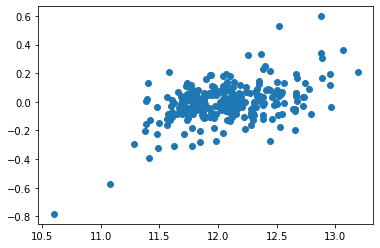

In [60]:
# answer below:
predict_y = best_grad.predict(X_test)
residual = y_test - predict_y

plt.scatter(y_test, residual)
plt.show()